This notebook will reproduce some aspects of the paper:
An Approach of electrical load profile analysis based on time series Data Mining 
Ying Shi,Tao Yu,Qianjin Liu,Hanxin Zhu,Fusheng Li,Yaxiong Wu

In order to analyse clusters of consumers, the authors propose the following approach:

1. Extract TLP of each Id
1. Extract Features: The authors propose 6 load shape indices and 4 load profile features based on time series
2. Use these features in a K-means clustering approach


The authors will extract features from TLP. In our case, this should be represented by 48points.Thus, the total data set should be m * 10, where m is the number of customers, and 10 is the dimension of features we have extracted from the TLP. 

### Features

1. Load factor
2. Maximum utilization rate
3. peak-valley difference ratio
4. Peak load factor
5. Flat load factor
6. Valley load factor

In [1]:
from scipy.stats import entropy
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pyts.approximation import PiecewiseAggregateApproximation
import matplotlib.pyplot as plt
from pyts.approximation import SymbolicAggregateApproximation
from scipy.stats import norm
import matplotlib.lines as mlines
from collections import Counter
import time
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [2]:
def load_factor(Pavg,Pmax):
    '''
    Consider a whole day(48timesteps):

    '''
    return Pavg/Pmax
    

In [3]:
def mur(Psum,Pmax):
    '''
    Maximum utilization rate
    Given a whole day:
    Psum = sum of the whole day
    Pmax = 
    
    '''
    return Psum/(24*Pmax)

In [4]:
def pvdr(Pmax,Pmin):
    '''
    Peak-valley difference ratio
    '''
    return (Pmax - Pmin)/Pmax

In [5]:
def plf(x,Pavg):
    '''
    Peak Load Factor
    between the hours of 8am-11am and 6pm-9pm
    Pavg: avg in total
    P_avg_pk : avg during these hours
    
    '''
    x = x.to_list()
    
    t1 = x[16:22]
    t2 = x[36:42]
    t_ = t1+t2
    P_avg_pk = np.mean(t_)
    return P_avg_pk/Pavg
    

In [6]:
def flf(x,Pavg):
    '''
    Flat load factor 
    6am-8am
    11am-6pm
    9pm-10pm
    This is the 'flat time'.
    Pavg: avg in total
    P_avg_fl: avg durind specific time
    ''' 
    x = x.to_list()
    t1 = x[12:16]
    t2 = x[22:36]
    t3 = x[42:44]
    P_avg_fl = np.mean(t1 + t2 + t3)
    return P_avg_fl/Pavg
    

In [7]:
def vlf(x,Pavg):
    '''
    Valley load factor
    10pm - 12am
    12am - 6am
    Pavg: avg in total 
    P_avg_v : avg in specific time
    '''
    x = x.to_list()
    t1 = x[44:47]
    t2 = x[:12]
    P_avg_v = np.mean(t1+t2)
    return P_avg_v/Pavg

#### Binned Entropy

Divide the load profile into several equidistane bins, [min(x),max(x)] can be divided into k bins, then the value
of the load profile can be distributed among the k bins


In [8]:
def BE(x,k):
    '''
    x: TFP
    k: no of bins 

    '''
    ent_ = pd.cut(x, bins=k).value_counts()/48
    return entropy(ent_)

#### Complexity-Invariant Distance CID

In [9]:
def CID(x,lag):
    cid_ = []
    for i in range(len(x)-1 - 2*lag):
        cid_.append((x[i] - x[i+1])**2)
    return sum(cid_)
        
        

#### Nonlinear metrics 

In [10]:
def nm(x,lag):
    nm_ = []
    for i in range(len(x)-1 -(2*lag)):
        nm_.append(x[i] * x[i+lag] * (x[i+2*lag])**2)
    return sum(nm_)/(len(x) - 2*lag)
        
        

#### Mean absolute Change

In [11]:
### can use pandas .mad method on a series

Create TLP for each LCLid, and then extract the above features from that profile

In [12]:
df = pd.read_csv('/home/usman/Documents/Smart-Meter-analysis/total_hhblock.csv')

In [13]:
df = df.iloc[:,1:]
LCLid_ = df.LCLid.unique()

In [14]:
LCLid_ = list(LCLid_)

In [16]:
LCLid_.remove('MAC004067')

In [35]:
def create_TLP(df,x):
    '''
    df: Complete dataset
    x: LCLid
    '''
    # create subset of data
    df_ = df[df.LCLid == x]
    print(x)
    # dropna
    df_ = df_.dropna()
    #Scale mean=0, sd = 1
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_.iloc[:,2:])
    
    n_samples, n_timestamps = df_.shape[0],df_.shape[1]

    # PAA transformation
    window_size = 8
    paa = PiecewiseAggregateApproximation(window_size=window_size)
    df_paa = paa.transform(df_scaled)
    
    # SAX
    n_bins = 4
    sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='normal')
    df_sax = sax.fit_transform(df_paa)
    
    # Extract motif and discord
    
    df_sax_ = []
    for x in df_sax:
        df_sax_.append(''.join(map(str, x)))
        
    df_sax_occurs = Counter(df_sax_)
    #get top 3
    use_sax = df_sax_occurs.most_common()[:9]
    get_tlp = pd.DataFrame(df_sax_,columns = ['sax'])
    use_sax = [x[0] for x in use_sax]
    
    sax_locs = []
    for x in use_sax:
        locs_ = get_tlp[get_tlp['sax'] == x]
        sax_locs.append(locs_)

    sax_index = [x.index.to_list() for x in sax_locs]
    sax_flat_index = [item for sublist in sax_index for item in sublist]
    
    df_tfp = df.loc[sax_flat_index]
    TLP = df_tfp.iloc[:,2:].mean()
    
    return TLP
    
    

In [36]:
# Create TLP for sample of IDs
start = time.time()
output = [create_TLP(df,x) for x in LCLid_]
end = time.time() - start

MAC000742
MAC000745
MAC000747
MAC000749
MAC000753
MAC000756
MAC000762
MAC000764
MAC000765
MAC000767
MAC001311
MAC001315
MAC001320
MAC001321
MAC001325
MAC001328
MAC001329
MAC001332
MAC001333
MAC001337
MAC001344
MAC001347
MAC001350
MAC001353
MAC001358
MAC001361
MAC001363
MAC001433
MAC001434
MAC001436
MAC002593
MAC002596
MAC002609
MAC002614
MAC002625
MAC002633
MAC002675
MAC002677
MAC002679
MAC002686
MAC002690
MAC002695
MAC002712
MAC002713
MAC004661
MAC004668
MAC004670
MAC004687
MAC004697
MAC004716
MAC000012
MAC000078
MAC000080
MAC000349
MAC000351
MAC000353
MAC000355
MAC000637
MAC000639
MAC000646
MAC000651
MAC000652
MAC000654
MAC000663
MAC000669
MAC001506
MAC001513
MAC001514
MAC001516
MAC001517
MAC001519
MAC001521
MAC001522
MAC001526
MAC001532
MAC001534
MAC001537
MAC001541
MAC001562
MAC001571
MAC001572
MAC002098
MAC002099
MAC002102
MAC002106
MAC002131
MAC002132
MAC002140
MAC002154
MAC002156
MAC002164
MAC002280
MAC002421
MAC002726
MAC004921
MAC004926
MAC004932
MAC004937
MAC004965
MAC004977


MAC001744
MAC001747
MAC001748
MAC001751
MAC001755
MAC001773
MAC001777
MAC001785
MAC001791
MAC001798
MAC001811
MAC001817
MAC001824
MAC001829
MAC001840
MAC001904
MAC002117
MAC002419
MAC002424
MAC002426
MAC002427
MAC002438
MAC002475
MAC002483
MAC002501
MAC002511
MAC005414
MAC005435
MAC005452
MAC005458
MAC000033
MAC000034
MAC000035
MAC000036
MAC000045
MAC000066
MAC000370
MAC000950
MAC000951
MAC000956
MAC000958
MAC000960
MAC000964
MAC000968
MAC000972
MAC000973
MAC000975
MAC000977
MAC000990
MAC001001
MAC001011
MAC001022
MAC001027
MAC001032
MAC001039
MAC001042
MAC001043
MAC001052
MAC001066
MAC001073
MAC001077
MAC001081
MAC001082
MAC001164
MAC001173
MAC001260
MAC002864
MAC002869
MAC002879
MAC002881
MAC003960
MAC003975
MAC003984
MAC004000
MAC004025
MAC004035
MAC004320
MAC004605
MAC004606
MAC004610
MAC000323
MAC000379
MAC000386
MAC000535
MAC000557
MAC000569
MAC000713
MAC000768
MAC000778
MAC000816
MAC000850
MAC000886
MAC000902
MAC000948
MAC000974
MAC001145
MAC001239
MAC001251
MAC001271
MAC001510


MAC005198
MAC005199
MAC005202
MAC005203
MAC005209
MAC005214
MAC005215
MAC005217
MAC005218
MAC005221
MAC000245
MAC000466
MAC000573
MAC000592
MAC000607
MAC000608
MAC000694
MAC000724
MAC000731
MAC000763
MAC000779
MAC003164
MAC003172
MAC003181
MAC003189
MAC003191
MAC003192
MAC003345
MAC003346
MAC003350
MAC003351
MAC003369
MAC003415
MAC003435
MAC003443
MAC003455
MAC003564
MAC003565
MAC003569
MAC003574
MAC003629
MAC003641
MAC003644
MAC003667
MAC003688
MAC003785
MAC003880
MAC004036
MAC004042
MAC004169
MAC004207
MAC004316
MAC004433
MAC004576
MAC004640
MAC004722
MAC004793
MAC005432
MAC005498
MAC005529
MAC000004
MAC000438
MAC000443
MAC000444
MAC000448
MAC000516
MAC000518
MAC000526
MAC000538
MAC000540
MAC000546
MAC000562
MAC001274
MAC001279
MAC001299
MAC001651
MAC001655
MAC001687
MAC001699
MAC001701
MAC001702
MAC001707
MAC001712
MAC001716
MAC001720
MAC001725
MAC001737
MAC001741
MAC001745
MAC001753
MAC001754
MAC001889
MAC001895
MAC001896
MAC001902
MAC001905
MAC005180
MAC005189
MAC005190
MAC005197


MAC001653
MAC001736
MAC001819
MAC001836
MAC002113
MAC002134
MAC002199
MAC002260
MAC002552
MAC002959
MAC003196
MAC003257
MAC003286
MAC003474
MAC003536
MAC003606
MAC003634
MAC003683
MAC003807
MAC003895
MAC004054
MAC004258
MAC004374
MAC004436
MAC004554
MAC004713
MAC004789
MAC004872
MAC004900
MAC004988
MAC004997
MAC005042
MAC005062
MAC005160
MAC005283
MAC005406
MAC005421
MAC005468
MAC005523
MAC000382
MAC000578
MAC000638
MAC000723
MAC000736
MAC001076
MAC001120
MAC002095
MAC002115
MAC002123
MAC002309
MAC002312
MAC002323
MAC002354
MAC002409
MAC002411
MAC002420
MAC002437
MAC002493
MAC002515
MAC002526
MAC002544
MAC002561
MAC002591
MAC003432
MAC003438
MAC003450
MAC003453
MAC003456
MAC003457
MAC003464
MAC003469
MAC003473
MAC003477
MAC003488
MAC003490
MAC003493
MAC003495
MAC003551
MAC003561
MAC003567
MAC003570
MAC003573
MAC003583
MAC003585
MAC003591
MAC003595
MAC003678
MAC003685
MAC003690
MAC000096
MAC000140
MAC000336
MAC000342
MAC000431
MAC000456
MAC000715
MAC000727
MAC001064
MAC001219
MAC001471


MAC002045
MAC002053
MAC002054
MAC002055
MAC002077
MAC002088
MAC002089
MAC002094
MAC002107
MAC002116
MAC002124
MAC002128
MAC002129
MAC002139
MAC002146
MAC002159
MAC005288
MAC000071
MAC000083
MAC000668
MAC000793
MAC000805
MAC000807
MAC000846
MAC000970
MAC000987
MAC001263
MAC001369
MAC001568
MAC001605
MAC001634
MAC001814
MAC001846
MAC002273
MAC002284
MAC002303
MAC002842
MAC002868
MAC003053
MAC003269
MAC003285
MAC003309
MAC003329
MAC003337
MAC003383
MAC003410
MAC003461
MAC003568
MAC003582
MAC003661
MAC003739
MAC003778
MAC003802
MAC003973
MAC004058
MAC004120
MAC004244
MAC004897
MAC004901
MAC004902
MAC004903
MAC005051
MAC005061
MAC005216
MAC005247
MAC005534
MAC000058
MAC000356
MAC000357
MAC000358
MAC000380
MAC000677
MAC000679
MAC000686
MAC000693
MAC000697
MAC000770
MAC001029
MAC001130
MAC001442
MAC001443
MAC001445
MAC001451
MAC001452
MAC001454
MAC001457
MAC001461
MAC001469
MAC001478
MAC001479
MAC001498
MAC001499
MAC001500
MAC001501
MAC001504
MAC001575
MAC002215
MAC002225
MAC002226
MAC002240


MAC000831
MAC000837
MAC000840
MAC000848
MAC000849
MAC000864
MAC001175
MAC001180
MAC001181
MAC001184
MAC001196
MAC001198
MAC001199
MAC001203
MAC001215
MAC001223
MAC001224
MAC001693
MAC001705
MAC001722
MAC001723
MAC001726
MAC001730
MAC001731
MAC001884
MAC001886
MAC002930
MAC002935
MAC002971
MAC002982
MAC003035
MAC003043
MAC003055
MAC003068
MAC003124
MAC003135
MAC003156
MAC004334
MAC004346
MAC004347
MAC004424
MAC004449
MAC005266
MAC005271
MAC005278
MAC000184
MAC000188
MAC000210
MAC000211
MAC000215
MAC000217
MAC000502
MAC000563
MAC000634
MAC000721
MAC000980
MAC003587
MAC003950
MAC003967
MAC004124
MAC004229
MAC004282
MAC004284
MAC004285
MAC004288
MAC004290
MAC004296
MAC004299
MAC004301
MAC004304
MAC004310
MAC004312
MAC004313
MAC004478
MAC004483
MAC004488
MAC004492
MAC004499
MAC004521
MAC004523
MAC004526
MAC004751
MAC004753
MAC004768
MAC004837
MAC004838
MAC004845
MAC004967
MAC005146
MAC005147
MAC005150
MAC005161
MAC005162
MAC005173
MAC005477
MAC000060
MAC000586
MAC000728
MAC000789
MAC001055


MAC003227
MAC003232
MAC003243
MAC003249
MAC003377
MAC003386
MAC003467
MAC003513
MAC003628
MAC003769
MAC003781
MAC003798
MAC003824
MAC004103
MAC004493
MAC004865
MAC005166
MAC005312
MAC005510
MAC005511
MAC005540
MAC005544
MAC000113
MAC000301
MAC000309
MAC002509
MAC002510
MAC002512
MAC002513
MAC002514
MAC002517
MAC002518
MAC002519
MAC002522
MAC002525
MAC002530
MAC002539
MAC002557
MAC002558
MAC002605
MAC002662
MAC002663
MAC002666
MAC002676
MAC002702
MAC002750
MAC002754
MAC002756
MAC002757
MAC002761
MAC002764
MAC002767
MAC005269
MAC005270
MAC005274
MAC005313
MAC005317
MAC005319
MAC005322
MAC005331
MAC005367
MAC005392
MAC005400
MAC005403
MAC005404
MAC005405
MAC005407
MAC005408
MAC005411
MAC005412
MAC005415
MAC005416
MAC000152
MAC000153
MAC000159
MAC000161
MAC000189
MAC000191
MAC000237
MAC003746
MAC003777
MAC003789
MAC003790
MAC003993
MAC003994
MAC004003
MAC004013
MAC004014
MAC004015
MAC004020
MAC004022
MAC004038
MAC004041
MAC004084
MAC004087
MAC004094
MAC004096
MAC004099
MAC004102
MAC004105


In [37]:
def create_features(x,k,lag):
    
    '''
    x: the TLP
    k: no of bins 
    lag: 
    '''
    Pavg = x.mean()
    Pmax = x.max()
    Pmin = x.min()
    Psum = x.sum()
    
    lf = load_factor(Pavg,Pmax)
    mur_ = mur(Psum,Pmax)
    pvdr_= pvdr(Pmax,Pmin)
    plf_= plf(x,Pavg)
    flf_= flf(x,Pavg)
    vlf_= vlf(x,Pavg)
    BE_ = BE(x,k)
    CID_ = CID(x,lag)
    nm_ = nm(x,lag)
    mac_ = x.mad()
    
    return [lf,mur_,pvdr_,plf_,flf_,vlf_,BE_,CID_,nm_,mac_]
    
    

In [38]:
feature_set = [create_features(x,5,2) for x in output]
feature_set = np.array(feature_set)

In [39]:
feature_set.shape

(5559, 10)

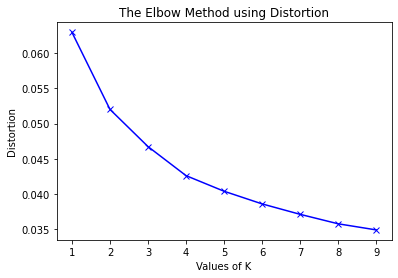

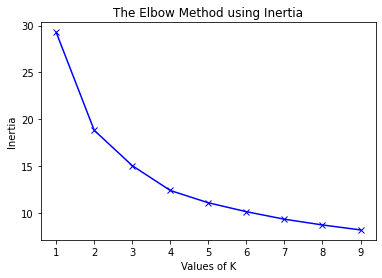

In [40]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = feature_set
for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k).fit(X)
	kmeanModel.fit(X)

	distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / X.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / X.shape[0]
	mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [41]:
kmeanModel = KMeans(n_clusters=4).fit(X)


In [42]:
labels_ = list(kmeanModel.labels_)

In [43]:
new_output = list(zip(labels_,output))

In [44]:
cluster_three = [x[1] for x in new_output if x[0] == 3 ]
cluster_two = [x[1] for x in new_output if x[0] == 2 ]
cluster_one = [x[1] for x in new_output if x[0] == 1 ]
cluster_zero = [x[1] for x in new_output if x[0] == 0 ]


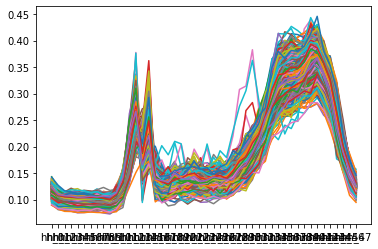

In [45]:
for i in range(len(cluster_three)):
    plt.plot(cluster_three[i])

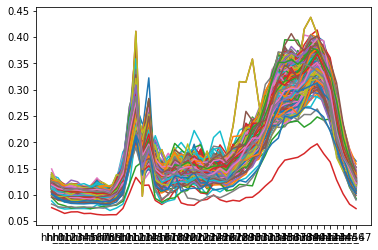

In [46]:
for i in range(len(cluster_two)):
    plt.plot(cluster_two[i])

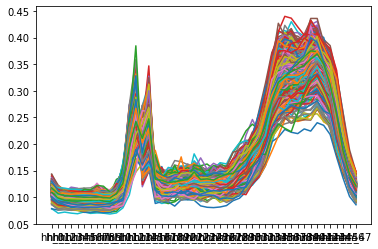

In [47]:
for i in range(len(cluster_one)):
    plt.plot(cluster_one[i])

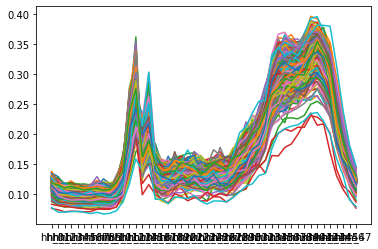

In [48]:
for i in range(len(cluster_zero)):
    plt.plot(cluster_zero[i])